In [1]:
# reading dataset
path = (r"C:\Users\USER\Desktop\Minor_Project\dataset")

In [2]:
import torch
from torchvision import datasets, transforms, models
# models allow us to import pre trained model into our code

# transformations are used to preprocess the dataset before it is fed to neural network
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# GPU Support
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# biodegradable and non biodegradable images are 224x224
#applying data augmentation transform to training dataset(only)
transform_train = transforms.Compose([transforms.Resize((224,224)),transforms.RandomHorizontalFlip(),transforms.RandomAffine(0,shear=10 ,scale=(0.8,1.2)),transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
#Compose allows us to chain together transformations

#we chose value 0.5 because we want values in range 0 to 1,creating a range (-1 to 1)

# Normalizing the image 
# formula z = (x - mean)/ standard deviation
# eg. (min value - mean)/standard deviation = (0-0.5)/0.5 = -1
# (max value- mean)/sd = (1-0.5)/0.5 =1  therefore range = (-1,1)

#Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) = Normalize(mean,standard deviation)
#Normalize the value of each tensor of image size channel height and widthin 1st set of brackets
#converts numpy array(of range 0-255) to tensor (a float tensor in range 0 to 1)

# defining root directory of training_dataset
training_dataset = datasets.ImageFolder('dataset/train',transform =transform_train )
validation_dataset = datasets.ImageFolder('dataset/val',transform =transform )


training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 20, shuffle = True)
validation_loader =torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 20, shuffle = False)

In [5]:
print(len(training_dataset))
print(len(validation_dataset))

1551
497


In [6]:
# to plot an image convert it again to a numpy array
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    # clone to create new copy of tensor
    # use detach function to call numpy
  
    image = image.transpose(1,2,0)
    # we have shape of tensor as(1,28,28)(single colorchannel,shape(28,28)) but to plot a grayscale image we need tensor of shape (28,28,1)
    # we swap axis using transpose means swap axis 0 for axis 1, axis 1 fo axis 2 and axis 0 in the end
    #print(image.shape)
    # denormalizing the image
    # x=z * standard deviation + mean
  
    image = image *np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    image = image.clip(0,1)
    # to reconvert range from (-1,1) to (1,1) we use clip function
    return image
    
  

In [7]:
!pip install Pillow==4.0.0

In [8]:
classes =('biodegradable','non_biodegradable')
#biodegradable belong to class 0 and non_biodegradable to class 1

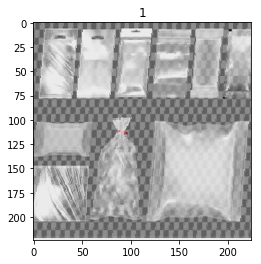

In [25]:
dataiter = iter(training_loader)
image, label = dataiter.next()
#lbl = 'label: ' + label[15].numpy()
plt.title(label[5].numpy())
plt.imshow(im_convert(image[5]))

In [26]:
from PIL import ImageFile

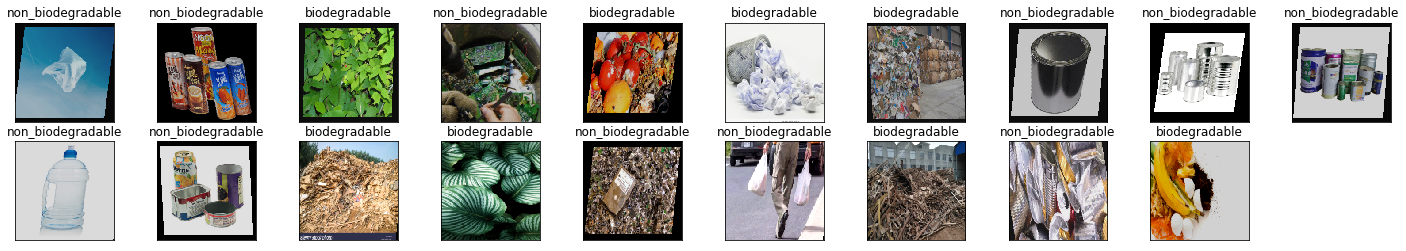

In [27]:
# creating a iterator 
# iter creates an object that allows us to go through the iterable of training loader one element at a time 
# .next takes a batch of 20 images each time the code is executed
dataiter = iter(training_loader)
images, labels = dataiter.next()

ImageFile.LOAD_TRUNCATED_IMAGES = True
#images , labels = dataiter.next()
#images, labels = dataiter.next() # gets first batch of training data
fig = plt.figure(figsize =(25,4))

for idx in np.arange(19):
    
    ax =fig.add_subplot(2,10,idx+1,xticks =[],yticks =[])   # 2 rows 10 columns per row and index
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [11]:
model =models.vgg11(pretrained =True)  # loading a pre trained model

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to C:\Users\USER/.cache\torch\checkpoints\vgg11-bbd30ac9.pth
100%|███████████████████████████████████████████████████████████████| 531456000/531456000 [2:27:27<00:00, 60070.63it/s]


In [12]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [13]:
# freeze the parameters inside feature extraction part of network such that convolutional layers are unaffected by the training
# keeping fully connected layers dynamic as we need them to learn which fetures are importantto classify for our dataset

# freezing parameters
for param in model.features.parameters():
    param.requires_grad = False

In [14]:
# to change the no. of output node from 1000 to 2 (no. of classes to distinguish)

import torch.nn as nn

n_inputs = model.classifier[6].in_features # asses 6th row of classifier to get input features
last_layer = nn.Linear(n_inputs,len(classes)) # change last layer output to length of classes i.e 2
model.classifier[6] = last_layer
model.to(device)
print(model.classifier[6].out_features)

2


In [15]:
# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [28]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
 
for e in range(epochs):
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
  
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    else:
        with torch.no_grad():
        
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
        
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
      
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/ len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
    
        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
 

epoch : 1
training loss: 0.5129, acc 18.1282 
validation loss: 0.7095, validation acc 17.6000 
epoch : 2
training loss: 0.5685, acc 18.3077 
validation loss: 2.1540, validation acc 16.6800 
epoch : 3
training loss: 0.7476, acc 18.3846 
validation loss: 0.6050, validation acc 18.1600 
epoch : 4
training loss: 0.3273, acc 18.9615 
validation loss: 1.6340, validation acc 17.6400 
epoch : 5
training loss: 0.4308, acc 18.8590 
validation loss: 0.4985, validation acc 18.2000 
epoch : 6
training loss: 0.3030, acc 18.9359 
validation loss: 0.9197, validation acc 18.2800 
epoch : 7
training loss: 0.4019, acc 19.2179 
validation loss: 2.6401, validation acc 17.5600 
epoch : 8
training loss: 0.2875, acc 19.1923 
validation loss: 1.9939, validation acc 17.8000 
epoch : 9
training loss: 0.3903, acc 19.1538 
validation loss: 1.4266, validation acc 18.4000 
epoch : 10
training loss: 0.3743, acc 19.1795 
validation loss: 1.5616, validation acc 18.6400 
epoch : 11
training loss: 0.4920, acc 19.2436 
va

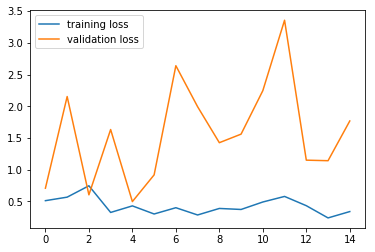

In [29]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label= 'validation loss')
plt.legend()

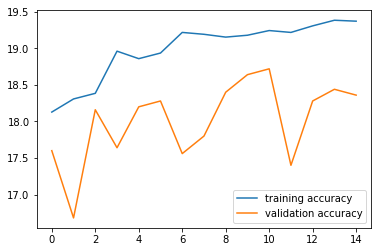

In [30]:
plt.plot(running_corrects_history ,label ='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [31]:
import PIL.ImageOps

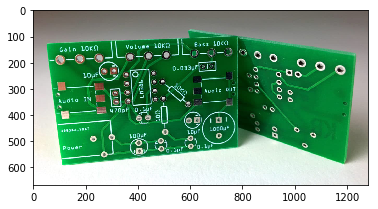

In [38]:
import requests
from PIL import Image
 
url = 'http://www.circuitbasics.com/wp-content/uploads/2016/06/How-to-Make-a-Custom-PCB-PCB-Final-Image.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

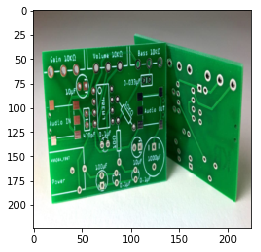

In [39]:
img = transform(img)
plt.imshow(im_convert(img))

In [40]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

non_biodegradable
